In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV

In [39]:
missions = pd.read_csv("space_missions_dataset.csv")

In [40]:
missions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Mission ID                         500 non-null    object 
 1   Mission Name                       500 non-null    object 
 2   Launch Date                        500 non-null    object 
 3   Target Type                        500 non-null    object 
 4   Target Name                        500 non-null    object 
 5   Mission Type                       500 non-null    object 
 6   Distance from Earth (light-years)  500 non-null    float64
 7   Mission Duration (years)           500 non-null    float64
 8   Mission Cost (billion USD)         500 non-null    float64
 9   Scientific Yield (points)          500 non-null    float64
 10  Crew Size                          500 non-null    int64  
 11  Mission Success (%)                500 non-null    float64

In [41]:
# Feature Editing and Preprocessing
missions['Target_Type_Code'] = missions['Target Type'].astype('category').cat.codes
missions['Mission_Type_Code'] = missions['Mission Type'].astype('category').cat.codes
missions['Launch_Vehicle_Code'] = missions['Launch Vehicle'].astype('category').cat.codes
missions['Target_Name_Code'] = missions['Target Name'].astype('category').cat.codes
missions['Mission_ID_Code'] = missions['Mission ID'].str.replace('MSN-', '', regex=True).astype(int)
missions['Launch Year'] = pd.to_datetime(missions['Launch Date']).dt.year

In [42]:
missions['Target Name'].value_counts()

Target Name
Proxima b     81
Mars          73
Io            72
Europa        70
Titan         70
Betelgeuse    67
Ceres         67
Name: count, dtype: int64

In [43]:
# Feature Engineering:
missions['Time Efficiency'] = missions['Scientific Yield (points)'] / (missions['Mission Duration (years)'] + 1e-5)
missions['Energy Demand'] = missions['Payload Weight (tons)'] * missions['Distance from Earth (light-years)']
missions['Target Distance'] = missions['Target_Name_Code'] * missions['Distance from Earth (light-years)']

In [44]:
missions.head()

,Mission ID,Mission Name,Launch Date,Target Type,Target Name,Mission Type,Distance from Earth (light-years),Mission Duration (years),Mission Cost (billion USD),Scientific Yield (points),...,Launch Vehicle,Target_Type_Code,Mission_Type_Code,Launch_Vehicle_Code,Target_Name_Code,Mission_ID_Code,Launch Year,Time Efficiency,Energy Demand,Target Distance
0,MSN-0001,Mission-1,2025-01-01,Star,Titan,Colonization,7.05,5.2,526.68,64.3,...,SLS,4,0,2,6,1,2025,12.365361,703.4490,42.30
1,MSN-0002,Mission-2,2025-01-08,Exoplanet,Betelgeuse,Colonization,41.76,23.0,234.08,84.4,...,Starship,1,0,3,0,2,2025,3.669564,1909.2672,0.00
2,MSN-0003,Mission-3,2025-01-15,Asteroid,Mars,Exploration,49.22,28.8,218.68,98.6,...,Starship,0,1,3,4,3,2025,3.423610,1777.8264,196.88
3,MSN-0004,Mission-4,2025-01-22,Exoplanet,Titan,Colonization,26.33,17.8,232.89,36.0,...,Starship,1,0,3,6,4,2025,2.022471,1070.8411,157.98
4,MSN-0005,Mission-5,2025-01-29,Exoplanet,Proxima b,Mining,8.67,9.2,72.14,96.5,...,Starship,1,2,3,5,5,2025,10.489119,107.5080,43.35


In [45]:
features = ['Target Distance', 'Payload Weight (tons)', 'Time Efficiency', 'Energy Demand', 'Distance from Earth (light-years)', 'Mission Duration (years)', 'Scientific Yield (points)', 'Target_Type_Code', 'Mission_Type_Code', 'Launch_Vehicle_Code', 'Target_Name_Code', 'Mission_ID_Code', 'Launch Year', 'Crew Size', 'Fuel Consumption (tons)', ]
target = 'Mission Cost (billion USD)'
missions[features] = StandardScaler().fit_transform(missions[features])

In [46]:
X = missions[features]
y = missions[target]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [48]:
tree = DecisionTreeRegressor(random_state = 42)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_test)
mse = mean_squared_error(y_test, y_pred_tree)
rmse = np.sqrt(mse)
print("Decision Tree RMSE:", rmse)

Decision Tree RMSE: 22.365435139965424


In [49]:
forest = RandomForestRegressor(n_estimators = 200, random_state=42)
forest.fit(X_train, y_train)

y_pred_forest = forest.predict(X_test)
mse = mean_squared_error(y_test, y_pred_forest)
rmse = np.sqrt(mse)
print("Forest Regressor RMSE:", rmse)

Forest Regressor RMSE: 16.37028087585317


In [54]:
print("R² Score:", r2_score(y_test, y_pred_forest) * 100, "%")
print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_forest) * 100, "%")

R² Score: 98.85203523685603 %
MAPE: 11.35006807445634 %


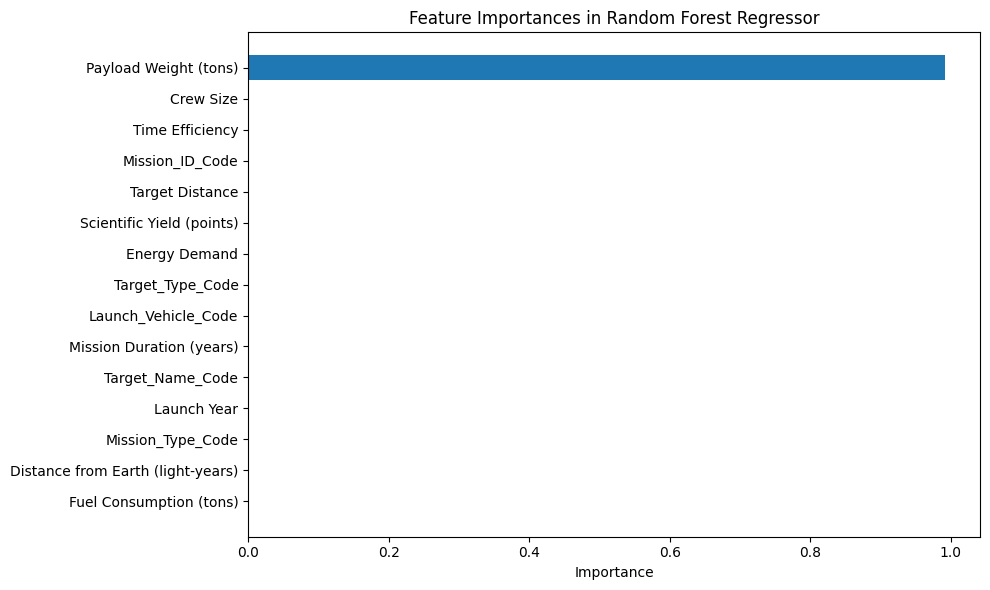

In [51]:
importances = forest.feature_importances_
feature_names = X.columns

# Sort by importance
indices = np.argsort(importances)[::-1]

# Plot the graph
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), [feature_names[i] for i in indices])
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest Regressor')
plt.gca().invert_yaxis()  # Most important at the top
plt.tight_layout()
plt.show()

## BarPlot Analysis:

As predicted previously based on the PairPlot and HeatMap, "Payload Weight" indeed is a very dominant feature after fitting, transforming, training and testing the model. This is not very good as it can lead to overfitting and the model becomes entirely dependent on it, essentially turning into a one-veriable function. A tiny noise in this feature could lead to wrong predictions. 

At this point, "Payload Weight" becomes a necessary evil as it is an essential factor for determining the cost of a space-ship. Hence, we will check its correlation with the target and try to reduce its influence using Lasso and Ridge Regression and analyzing the bias and variance.

In [52]:
# Dominant Feature Correlation
missions[['Payload Weight (tons)', 'Mission Cost (billion USD)']].corr()

,Payload Weight (tons),Mission Cost (billion USD)
Payload Weight (tons),1.000000,0.994838
Mission Cost (billion USD),0.994838,1.000000


In [55]:
ridge_cv = RidgeCV(alphas=[0.1, 1, 10, 100, 500, 1000])
ridge_cv.fit(X_train, y_train)
print("Best alpha:", ridge_cv.alpha_)

ridge = Ridge(alpha = 100)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("R2 Score: ", r2_score(y_test, y_pred_ridge))
print("Ridge Coefficients: ", ridge.coef_)
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_ridge)))

Best alpha: 1.0
R2 Score:  0.9460699594463589
Ridge Coefficients:  [ 0.48524856 92.10991655 -0.2699517  35.70620533 -7.74883475 -7.23976563
  0.51991407 -2.16655617  0.64285994  1.43310891 -2.50020708  0.77751764
  1.5140909   0.35568528 -7.72541337]
RMSE:  35.481929251494854


## Final Analysis:

Even after performing Ridge Regression and finding the best alpha parameter for Ridge, the feature's coefficient remains dominating (close to 100) with the model having an R2 score of ~94% which seems reasonable now as the model is not overly dependent on just one single feature. 